In [1]:
from paretoset import paretoset
import pandas as pd 
import numpy as np
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
from scipy.spatial import distance
from utils import *
import copy 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Configurations and Settings

In [2]:
calculate_cpu_mem_costs()

# benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "classifier": "bridge-8k-1920x1200", "linpack": "5000", "s3": "cats-1"}
# benchmarks = {
#             "transcode": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5", "video-6", "video-7", "video-8", "video-9", "video-10"], 
#             "pigo-faceblur": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "pigo-face-detector": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "openfaas-ocr": ["doc", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"], 
#             "linpack": ["2500","1000", "5000", "7500"],
#             "s3": ["cats-1", "video-1", "video-2", "video-3", "video-4", "video-5", "video-6", "video-7", "video-8", "video-9", "video-10"]
#             }

benchmarks = {
            "transcode": ["cats-1"], 
            "pigo-faceblur": ["faces2"], 
            "pigo-face-detector": ["faces2"], 
            "openfaas-ocr": ["doc"], 
            "linpack": ["2500"],
            "s3": ["cats-1"]
            }

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

# benchmarks ={"classifier": ["bridge-8k-1920x1200"]}

base_estimator = 'GP'
CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

N_TRIALS = 20
N_INIT_SAMPLES = 3
N_OPT_TRAILS = 10

data_dir = 'analysis_data/'

## Helper functions

In [3]:
def train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime'):
    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    runtimes = []
    costs = []

    minimum = 600.0
    best_config = {}

    init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
    # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

    default_config = init_samples[0]
    config = default_config
    # print(config)

    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    for i in range(0, N_TRIALS):
        success = True

        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        # runtimes.append(result)

        if result < minimum:
            minimum = result
            best_config = config 
        # print(result, config)

        model.update(config, result, function_name, success=True)
        
        if i < N_INIT_SAMPLES-1:
            config = init_samples[i+1]
        else:
            config = model.get_next_config(function_name)
        
    return model, best_config 

In [4]:
def train_model_weighted(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, min_value):
    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)


    minimum = 10000.0
    best_config = {}

    init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
    # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

    default_config = init_samples[0]
    config = default_config
    # print(config)

    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    runtime_weight = 0.5
    cost_weight = 0.5

    for i in range(0, N_TRAILS):
        success = True
        runtime = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='runtime')
        norm_runtime = runtime/float(min_value['runtime'])
        cost = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
        norm_cost = cost/float(min_value['cost'])
        result = norm_runtime * runtime_weight + norm_cost * cost_weight
        # print(result) 

        if result < minimum:
            minimum = result
            # minimum_runtime = runtime 
            # minimum_cost = cost 
            best_config = copy.deepcopy(config)


        model.update(config, result, function_name, success=True)
        
        if i < N_INIT_SAMPLES-1:
            config = init_samples[i+1]
        else:
            config = model.get_next_config(function_name)
        
    return model, best_config 

## Creating a combined pareto band

In [5]:
def similar_to_pareto_front(paretoset, model, function_name, data_name, min_cost, min_runtime, threshold=0.1):
    paretoset_performance =  pd.DataFrame(columns=["Function Runtime (s)", "Function Exec. Cost ($)", "Configs", "Data"])
    predictions = model.get_all_config_predictions(function_name)
    # print(predictions[0])
    for index, row in paretoset.iterrows():
        row_runtime = row["Function Runtime (s)"]
        row_cost = row["Function Exec. Cost ($)"]
        for prediction in predictions:
            runtime = prediction[0]/min_runtime 
            instance_type, cpu, memory = prediction[1]
            cost = calculate_cost(cpu, memory, prediction[0], instance_type)/min_cost
            if ((1-threshold)* row_runtime <= runtime) and (runtime <= (1+ threshold) * row_runtime) and \
                ((1-threshold)* row_cost <= cost) and (cost <= (1+ threshold) * row_cost):
                # print(prediction[1])
                # print(cost, runtime)
                config = {'instance_type': instance_type, 'cpu': cpu, 'memory': memory}
                runtime = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
                cost = calculate_cost(cpu, memory, runtime, instance_type)
                # print(cost, runtime)
                cost = cost/min_cost
                runtime = runtime/min_runtime

                # print(cost, runtime)
                paretoset_performance = paretoset_performance.append({"Function Runtime (s)": runtime,
                                                                      "Function Exec. Cost ($)": cost, 
                                                                      "Configs": instance_type + '_' + cpu + '_' + memory,
                                                                      "Data": data_name}, ignore_index=True)
    
    paretoset_performance.drop_duplicates(inplace=True)
    return paretoset_performance



In [6]:
# fig, axs = plt.subplots(figsize=(32, 4), ncols=6)
# j = 0
# matplotlib.rcParams.update({'font.size': 16})
paretoband = {}

for function_name in benchmarks.keys():
    print(function_name)
    paretoset_performance =  pd.DataFrame(columns=["Function Runtime (s)", "Function Exec. Cost ($)", "Configs", "Data", "Opt Trial"])

    data_name = benchmarks[function_name][0]

    # minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')
    # minimum_runtime, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)
    
    for x in range(0, N_OPT_TRAILS):
        runtimes = []
        costs = []
        configs = []

        model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime')
        minimum_runtime = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS)

        cost_model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='cost')
        minimum_cost = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS, metric='cost')
            
        # min_value = {'runtime': minimum_runtime, 'cost': minimum_cost}

        # model, best_config = train_model_weighted(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, min_value)
        # minimum = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS, metric='0.5/0.5')

        results = model.get_all_config_predictions(function_name)
        for result in results:
            runtimes.append(result[0]/minimum_runtime)
            instance_type = result[1][0]
            cpu = result[1][1]
            memory = result[1][2]
            costs.append(calculate_cost(cpu, memory, result[0], instance_type)/minimum_cost)
            configs.append(instance_type+'_'+cpu+'_'+memory)

        ## Test the pareto front configurations
        # performance = pd.DataFrame({"Function Runtime (s)": runtimes, 
        #         "Function Exec. Cost ($)": costs})
        # mask = paretoset(performance, sense=["min", "min"])
        # performance = performance[mask]
        # configs = np.array(configs)
        # configs = configs[mask]
        # performance["Configs"] = list(configs)
        # performance["Data"] = [data_name] * len(configs)
        # # paretoset_performance = paretoset_performance.append(performance, ignore_index=True)

        # # Update the model 
        # for index, row in performance.iterrows():
        #     config = {'instance_type': row["Configs"].split('_')[0], 'cpu': row["Configs"].split('_')[1], 'memory': row["Configs"].split('_')[2]}
        #     result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
        #     model.update(config, result, function_name, success=True)

        # configs=[]
        # runtimes=[]
        # costs=[]
        # results = model.get_all_config_predictions(function_name)
        # for result in results:
        #     runtimes.append(result[0]/minimum_runtime)
        #     instance_type = result[1][0]
        #     cpu = result[1][1]
        #     memory = result[1][2]
        #     costs.append(calculate_cost(cpu, memory, result[0], instance_type)/minimum_cost)
        #     configs.append(instance_type+'_'+cpu+'_'+memory)


        performance = pd.DataFrame({"Function Runtime (s)": runtimes, 
                "Function Exec. Cost ($)": costs})
        mask = paretoset(performance, sense=["min", "min"])
        performance = performance[mask]
        configs = np.array(configs)
        configs = configs[mask]
        performance["Configs"] = list(configs)
        performance["Data"] = [data_name] * len(configs)
        performance["Opt Trial"] = [x] * len(configs)
        paretoset_performance = paretoset_performance.append(performance, ignore_index=True)

        # print(performance)
    paretoband[function_name] = paretoset_performance
        # paretoband[function_name] = similar_to_pareto_front(performance, model, function_name, data_name, minimum_cost, minimum_runtime, threshold=0.0)

        # print(paretoband[function_name])

#     ax = sns.scatterplot(data=paretoset_performance, x='Function Runtime (s)', y='Function Exec. Cost ($)', hue='Data', ax=axs[j], alpha=0.5)
#     ax.legend().set_visible(False)

#     j += 1

    paretoband[function_name].to_csv(data_dir + function_name +'-paretoband-20-trials.csv', index=False)

# plt.savefig('pareto-set.pdf', bbox_inches = "tight")

transcode
pigo-faceblur
pigo-face-detector
openfaas-ocr
linpack
s3


## Calculate the distance between the points in the pareto front

In [7]:
def distance_from_ideal_paretoset(paretoband, performance):
    distances = []
    distances_runtime = []
    distances_cost = []
    # Measure distance of each point in the band to actual pareto front
    # the use the distance to the closest 
    for index, entry in paretoband.iterrows():
        distance_array = []
        for index, pareto_config in performance.iterrows():
            distance_array.append(distance.cityblock(
                [pareto_config["Function Runtime (s)"], pareto_config["Function Exec. Cost ($)"]],
                [entry["Function Runtime (s)"], entry["Function Exec. Cost ($)"]]
            ))
        minimum = min(distance_array)
        min_index = distance_array.index(minimum)
        distances.append(minimum)
        # print(entry["Function Runtime (s)"], performance["Function Runtime (s)"].iloc[min_index])
        distances_runtime.append(abs(entry["Function Runtime (s)"] - performance["Function Runtime (s)"].iloc[min_index])/performance["Function Runtime (s)"].iloc[min_index])
        distances_cost.append(abs(entry["Function Exec. Cost ($)"] - performance["Function Exec. Cost ($)"].iloc[min_index])/performance["Function Exec. Cost ($)"].iloc[min_index])
    
    return distances, distances_runtime, distances_cost

In [8]:
# benchmarks ={"pigo-face-detector": ["faces2", "image-1", "image-2", "image-3", "image-4", "image-5", "image-6", "image-7", "image-8", "image-9", "image-10"]}

for function_name in benchmarks.keys():
    print(function_name)
    # runtimes = pd.DataFrame(columns=['trials', 'runtime', 'cost', 'estimator'])
    paretoset_performance =  pd.DataFrame(columns=["Function Runtime (s)", "Function Exec. Cost ($)", "Configs", "Data"])

    distance_to_pareto = pd.DataFrame(columns=["Dataname", "Performance Metric", "Normalized Metric Value", "Trial"])

    for data_name in benchmarks[function_name]:

        print(data_name)
        for x in range(0, N_OPT_TRAILS):
            # model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime')
            # minimum_runtime = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS)

            # model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='cost')
            # minimum_cost = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS, metric='cost')
            runtimes = []
            costs = []
            configs = []
            
            minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')
            minimum_runtime, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)
                
            # results = model.get_all_config_predictions(function_name)
            # for result in results:
            #     runtimes.append(result[0])
            #     instance_type = result[1][0]
            #     cpu = result[1][1]
            #     memory = result[1][2]
            #     costs.append(calculate_cost(cpu, memory, result[0], instance_type))
            #     configs.append(instance_type+'_'+cpu+'_'+memory)

            for instance_type in instance_types:
                for cpu in CPU_LIMITS:
                    for mem in MEMORY_LIMITS:
                        # directory = "../data/" + benchmark + "/"
                        config = {'instance_type': instance_type, 'memory': mem.strip('Mi'), 'cpu': cpu.strip('m')}
                        median = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
                        
                        cost = calculate_cost(cpu, mem, median, instance_type)
                        runtimes.append(median/minimum_runtime)
                        costs.append(cost/minimum_cost)
                        configs.append(instance_type+'_'+cpu.strip('m')+'_'+mem.strip('Mi'))

            performance = pd.DataFrame({"Function Runtime (s)": runtimes, 
                    "Function Exec. Cost ($)": costs})
            mask = paretoset(performance, sense=["min", "min"])
            performance = performance[mask]
            configs = np.array(configs)
            configs = configs[mask]
            performance["Configs"] = list(configs)
            performance["Data"] = [data_name] * len(configs)

            function_pareto = paretoband[function_name]
            function_pareto_trial = function_pareto[function_pareto["Opt Trial"]==x]

            distances, distances_runtime, distances_cost = distance_from_ideal_paretoset(function_pareto_trial, performance)
            # print(distances)
            # print(distances_runtime)
            # print(distances_cost)

            df = pd.DataFrame(columns=["Dataname", "Performance Metric", "Normalized Metric Value", "Trial"])
            df["Dataname"] = [data_name] * len(distances)
            df["Performance Metric"] =  ["Runtime"] * len(distances)
            df["Normalized Metric Value"] = distances_runtime
            df["Trial"] = x
            distance_to_pareto = distance_to_pareto.append(df, ignore_index=False)

            df = pd.DataFrame(columns=["Dataname", "Performance Metric", "Normalized Metric Value", "Trial"])
            df["Dataname"] = [data_name] * len(distances)
            df["Performance Metric"] =  ["Execution Cost"] * len(distances)
            df["Normalized Metric Value"] = distances_cost
            df["Trial"] = x
            distance_to_pareto = distance_to_pareto.append(df, ignore_index=False)
        
    distance_to_pareto.to_csv(data_dir + function_name +'-distance-to-pareto-20-trials.csv', index=False)
    # -distance-to-pareto-0.0.csv is the one we used in the paper
    # -distance-to-pareto-40-trials.csv is with 40 optimization trials to see how much reduction in distance we can get


transcode
cats-1
pigo-faceblur
faces2
pigo-face-detector
faces2
openfaas-ocr
doc
linpack
2500
s3
cats-1


## Next Block Not used in the paper

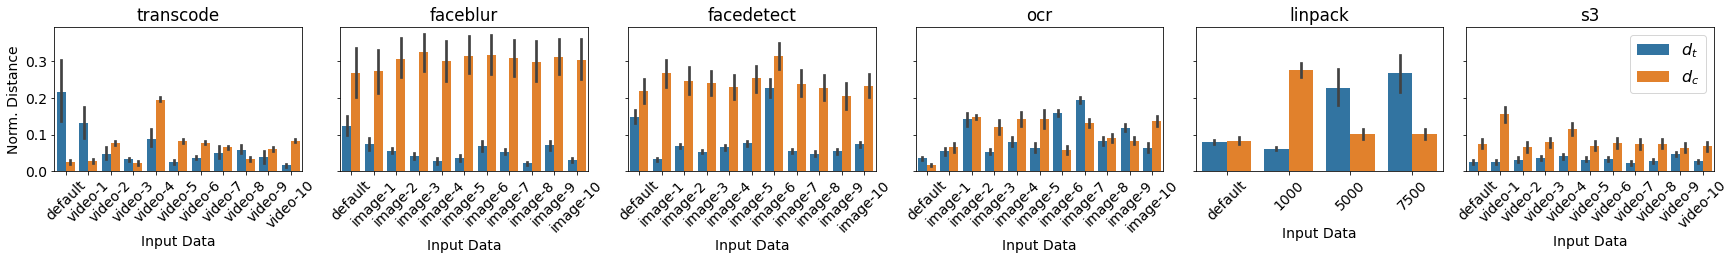

In [5]:
fig, axs = plt.subplots(figsize=(24, 3.5), ncols=6, constrained_layout=True, sharey=True)
j = 0
matplotlib.rcParams.update({'font.size': 14})
for function_name in benchmarks.keys():
    distance_to_pareto = pd.read_csv(data_dir + function_name +'-distance-to-pareto-20-trials.csv')
    distance_to_pareto.replace({'bridge-8k-1920x1200': 'default', 'faces2': 'default', 'cats-1': 'default', 2500: 'default', 'doc': 'default'}, inplace=True)
    distance_to_pareto.replace({'Runtime': '$d_{t}$', 'Execution Cost': '$d_{c}$'}, inplace=True)
    ax = sns.barplot(data=distance_to_pareto, x="Dataname", y="Normalized Metric Value", hue="Performance Metric", ax=axs[j])
    
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(benchmark_naming[function_name])
    ax.set_xlabel("Input Data")
    if j==0:
        ax.set_ylabel('Norm. Distance')
    else:
        ax.set_ylabel('')

    ax.legend().set_visible(False)
    # ax.set_ylabel
    j+=1 

matplotlib.rcParams.update({'font.size': 16})
plt.legend()
# plt.savefig('plots/pareto_distance_20_trials.pdf', bbox_inches = "tight")

## Normalized average distance between the points of predicted and actual pareto front

cats-1
7.1
faces2
9.2
faces2
9.8
doc
3.6
2500
7.4
cats-1
12.6


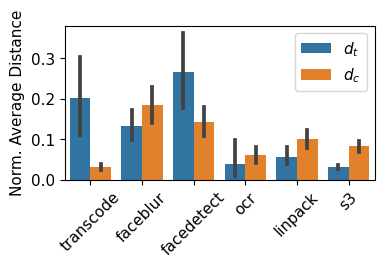

In [9]:
# fig, axs = plt.subplots(figsize=(24, 3.5), ncols=6, constrained_layout=True, sharey=True)
plt.figure(figsize=(4,2))
distance = pd.DataFrame()

j = 0
matplotlib.rcParams.update({'font.size': 11})
for function_name in benchmarks.keys():
    print(benchmarks[function_name][0])
    distance_to_pareto = pd.read_csv(data_dir + function_name +'-distance-to-pareto-20-trials.csv')
    if function_name == "linpack":
        distance_to_pareto = distance_to_pareto[distance_to_pareto['Dataname']==int(benchmarks[function_name][0])]
    else:
        distance_to_pareto = distance_to_pareto[distance_to_pareto['Dataname']==benchmarks[function_name][0]]
    
    print(len(distance_to_pareto.index)/20.0)
    distance_to_pareto.replace({'bridge-8k-1920x1200': 'default', 'faces2': 'default', 'cats-1': 'default', 2500: 'default', 'doc': 'default'}, inplace=True)
    distance_to_pareto.replace({'Runtime': '$d_{t}$', 'Execution Cost': '$d_{c}$'}, inplace=True)

    distance_to_pareto["Benchmark"] = [benchmark_naming[function_name]] * len(distance_to_pareto.index)
    distance = distance.append(distance_to_pareto)

ax = sns.barplot(data=distance, x="Benchmark", y="Normalized Metric Value", hue="Performance Metric")
# ax.set_title(benchmark_naming[function_name])
ax.set_xlabel("")
ax.set_ylabel('Norm. Average Distance')

ax.legend().set_visible(False)
    # ax.set_ylabel
ax.tick_params(axis='x', rotation=45)
matplotlib.rcParams.update({'font.size': 11})
plt.legend()
plt.savefig('plots/pareto_distance_20_trials.pdf', bbox_inches = "tight")

# Model building for pareto-front specifically

In [ ]:
def get_init_samples(cpu_options, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES):
    pass

In [3]:
def error_across_all_configs(model, function_name, metric='runtime'):
    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)

    actual_performance = []
    for i in range(0, len(model_all_predictions)):
        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_performance.append((result, conf))

    mae = 0.0
    for i in range(0, len(model_all_predictions)):
        e = abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        # if e*100 > 50.0:
        #     print(actual_performance[i][0], model_all_predictions[i])
        mae += e
    
    mae = 100*mae/float(len(model_all_predictions))

    return mae

## Ignore the subsequent code (not used in the paper)

classifier


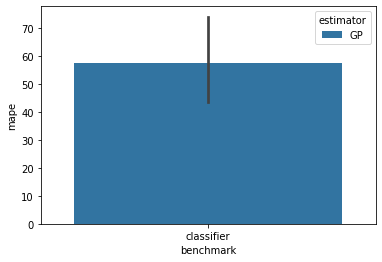

In [14]:
# fig, axs = plt.subplots(figsize=(32, 4), ncols=6)
# j = 0
# matplotlib.rcParams.update({'font.size': 16})
errors = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])

paretoband = {}

for function_name in benchmarks.keys():
    print(function_name)
    paretoset_performance =  pd.DataFrame(columns=["Function Runtime (s)", "Function Exec. Cost ($)", "Configs", "Data"])

    data_name = benchmarks[function_name][0]

    minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')
    minimum_runtime, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)
    
    for x in range(0, N_OPT_TRAILS):
        runtimes = []
        costs = []
        configs = []
        tested_configs = []
        tested_configs_performance = []

        minimum = 600.0

        init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)

        default_config = init_samples[0]
        config = default_config
        # print(config)
        
        if base_estimator != "poly":
            from optimizer.boskopt_noncat import Models
            model = Models()
            model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
        else:
            from optimizer.polyreg import Models
            model = Models()
            model.create_model(function=function_name)

        is_new_config = True
        for i in range(0, N_TRIALS):
            success = True

            result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
            tested_configs_performance.append(result)
            # runtimes.append(result)

            # print(config)
            # configs.append(config['instance_type'] + '_' + config['cpu'] + '_' + config['memory'])

            # cost = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
            # costs.append(cost)

            model.update(config, result, function_name, success=True)
            tested_configs.append(config)
            
            
            if i < N_INIT_SAMPLES-1:
                config = init_samples[i+1]
            else:
                config = model.get_next_config(function_name)
                is_new_config = config not in tested_configs
                while not is_new_config:
                    index = tested_configs.index(config)
                    result = tested_configs_performance[index]
                    model.update(config, result, function_name, success=True)
                    config = model.get_next_config(function_name)
                    is_new_config = config not in tested_configs
            
        mae = error_across_all_configs(model, function_name, metric='runtime')
        errors = errors.append({'benchmark': function_name, 'trials': x, 'mape': mae, 'estimator': base_estimator}, ignore_index=True)

        # results = model.get_all_config_predictions(function_name)
        # for result in results:
        #     runtimes.append(result[0]/minimum_runtime)
        #     instance_type = result[1][0]
        #     cpu = result[1][1]
        #     memory = result[1][2]
        #     costs.append(calculate_cost(cpu, memory, result[0], instance_type)/minimum_cost)
        #     configs.append(instance_type+'_'+cpu+'_'+memory)

        # performance = pd.DataFrame({"Function Runtime (s)": runtimes, 
        #         "Function Exec. Cost ($)": costs})
        # mask = paretoset(performance, sense=["min", "min"])
        # performance = performance[mask]
        # configs = np.array(configs)
        # configs = configs[mask]
        # performance["Configs"] = list(configs)
        # performance["Data"] = [data_name] * len(configs)
        # paretoset_performance = paretoset_performance.append(performance, ignore_index=True)


        # paretoband[function_name] = similar_to_pareto_front(performance, model, function_name, data_name, minimum_cost, minimum_runtime, threshold=0.05)
        # print(paretoband[function_name])
ax = sns.barplot(data=errors, x='benchmark', y='mape', hue='estimator')
plt.show()
#     ax = sns.scatterplot(data=paretoset_performance, x='Function Runtime (s)', y='Function Exec. Cost ($)', hue='Data', ax=axs[j], alpha=0.5)
#     ax.legend().set_visible(False)

#     j += 1

# plt.savefig('pareto-set.pdf', bbox_inches = "tight")